# Проект - переработка золота

## Общая информация

- Данные находятся в трёх файлах:
    
    - gold_recovery_train_new.csv — обучающая выборка;
    - gold_recovery_test_new.csv — тестовая выборка;
    - gold_recovery_full_new.csv — исходные данные.

- Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

- Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

- Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

- Имеются сырые данные. Прежде чем приступить к построению модели, проверим их корректность.

## Описание параметров

### Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

### Параметры этапов

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков

    Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
    
    Пример: rougher.input.feed_ag
    
Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

### Расчёт эффективности

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле:

Recovery = (C*(F-T)) / (F*(C-T)) * 100%

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

### Метрика качества

Используем метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентне отклонение»).

- Необходимо спрогнозировать две величины
    1. Эффективность обогащения чернового концентрата rougher.output.recovery;
    2. Эффективность обогащения финального концентрата final.output.recovery.

## Критерии проверки проекта

- Насколько хорошо данные подготовлены и проанализированы
- Какие строятся модели
- Как проверяется их качество
- Все ли шаги инструкции выполняются
- Поддерживается ли структура проекта и правильно ли выполняются шаги
- Какие получаются выводы
- Поддерживается ли аккуратность кода, нет ли дублирования

# Выполнение проекта

## Загрузка и общий анализ данных

### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from scipy import stats as st

from math import sqrt

pd.set_option('mode.chained_assignment', None)

In [2]:
try:
    df_train=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/071_Final project - Module 2/gold_recovery_train_new.csv')
except:
    df_train=pd.read_csv('/datasets/gold_recovery_train_new.csv')
    
try:
    df_test=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/071_Final project - Module 2/gold_recovery_test_new.csv')
except:
    df_test=pd.read_csv('/datasets/gold_recovery_test_new.csv')

try:
    df_full=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/071_Final project - Module 2/gold_recovery_full_new.csv')
except:
    df_full=pd.read_csv('/datasets/gold_recovery_full_new.csv')
    
df_all=[df_train,df_test,df_full] 

In [3]:
for data in df_all:
    
    display(data.head())
    display(data.shape)
    

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(14149, 87)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


(5290, 53)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(19439, 87)

In [4]:
df_train.info()
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


### Проверка расчета эффективности обогащения

Напишем функцию для расчета эффективности обогащения. 

In [7]:
def gold_recovery(C,F,T):
    return ((C*(F-T))/(F*(C-T)))*100

Переведем в датафрейм и выберем нужные столбцы

In [8]:
def gold_recovery_df(df_train):
    
    C = df_train['rougher.output.concentrate_au']
    F = df_train['rougher.input.feed_au']
    T = df_train['rougher.output.tail_au']
    
    return gold_recovery(C,F,T)
    

Так мы применяем функцию к датафрейму, будем использовать apply

In [9]:


selected_columns=['rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery']

df_train_selected=df_train[selected_columns]
display(df_train_selected.head())
display(df_train_selected.info())
df_train_selected['rougher.output.recovery.checked']=df_train_selected.apply(gold_recovery_df, axis=1)


,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
0,19.793808,6.486150,1.170244,87.107763
1,20.050975,6.478583,1.184827,86.843261
2,19.737170,6.362222,1.162562,86.842308
3,19.320810,6.118189,1.079755,87.226430
4,19.216101,5.663707,1.012642,86.688794


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.concentrate_au  14149 non-null  float64
 1   rougher.input.feed_au          14149 non-null  float64
 2   rougher.output.tail_au         14149 non-null  float64
 3   rougher.output.recovery        14149 non-null  float64
dtypes: float64(4)
memory usage: 442.3 KB


None

Вычислим MAE

In [10]:
mae = mean_absolute_error(df_train_selected['rougher.output.recovery'], df_train_selected['rougher.output.recovery.checked'])

print("MAE между задаными и рассчитаными значениями составляет",mae)

MAE между задаными и рассчитаными значениями составляет 9.73512347450521e-15


### Выводы по расчету эффективности обогащения

- Ошибка между задаными и рассчитаными значениями практически нулевая - эффективность обогащения рассчитана верно

### Анализ признаков в тестовой выборке

- Тестовая выборка содержит существенно меньше столбцов чем обучающая, проверим какие столбцы в обучающей лишние

In [11]:
exceed_columns = [ elem for elem in list(df_train.columns) ]
for item in list(df_test.columns):
    if item in list(df_train.columns):
        exceed_columns.remove(item)
        
display(exceed_columns)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

- В обучающей выборке присутствуют дополнительные столбцы - судя по названиями это результаты некоторых промежуточных вычислений. Нам неизвестен точный способ их вычисления и они будут мешать обучению модели

## Предобработка данных

- По условиям задачи - данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Значит будем использовать дату для индексирования данных в разных таблицах
- Стоблцов станет на один меньше - мы перевели дату в индекс

### Индексация

In [12]:
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')
df_full = df_full.set_index('date')

На предыдущем шаге мы установили, что в обучающей выборке есть лишние столбцы - удалим их

In [13]:
df_train=df_train[df_test.columns]

In [14]:
display(df_train.shape)
display(df_test.shape)

(14149, 52)

(5290, 52)

### Обработка пропусков

- Проверим количество пропусков в данных

In [15]:
display(df_full.isna().sum().sum())

4481

In [16]:
display(df_train.isna().sum().sum())

1705

In [17]:
display(df_train.isna().sum())

primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank10_xanthate              8


In [18]:
display(df_test.isna().sum().sum())

90

In [19]:
display(df_train.isna().sum())

primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank10_xanthate              8


Логично предположить, что пропуски в тествой и обучающей выборках могут перекрываться данными из полной выборки

In [20]:
df_train = df_train.fillna(df_full)
df_test = df_test.fillna(df_full)

display(df_train.isna().sum().sum())
display(df_test.isna().sum().sum())

1705

90

Попробовали заполнить данными из полной выборки - не помогло

Посмотрим подробнее как выглядят пропуски

In [21]:
df_train[df_train['rougher.input.floatbank11_xanthate'].isna()].head(10)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,15.273131,1.940663,7.25,0.180119,1546.951271,-501.138590,1550.530280,-500.130616,1551.535239,-502.251161,...,13.947368,-703.993293,12.018188,-559.800324,9.999754,-512.673353,7.946763,-500.475471,11.963962,-607.847547
2016-01-21 10:00:00,NaN,NaN,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-02 11:00:00,NaN,0.012373,7.62,0.001285,1602.198286,-450.681741,1600.252087,-449.323651,1599.761123,-448.628056,...,13.974818,-578.520549,14.065672,-501.248199,12.011447,-500.417855,10.025794,-499.889108,20.033958,-499.999036
2016-05-15 13:59:59,159.551841,11.972081,7.74,0.904101,1203.830417,-499.751674,1204.874868,-499.591962,1201.389978,-500.573755,...,9.989485,-501.018930,8.028083,-504.302157,8.806407,-499.302177,5.980273,-500.507677,20.006564,-496.164292
2016-05-15 14:59:59,58.717323,12.027662,6.61,0.922359,1392.770893,-500.326034,1299.437987,-499.958419,1203.788552,-496.356381,...,10.012410,-501.591840,7.907263,-513.814631,8.568602,-498.174475,5.968032,-499.963947,19.985684,-503.306448
2016-06-06 13:59:59,0.832935,NaN,6.80,0.010702,1191.181589,-502.140749,1192.766017,-494.615276,1193.561361,-635.561247,...,10.016232,-591.105501,8.034319,-547.173732,7.957247,-495.834105,6.025972,-500.221367,18.015904,-495.628009
2016-06-30 18:59:59,0.129139,NaN,7.31,0.004816,531.926222,-498.328181,545.991544,-501.589520,510.630950,-532.511890,...,16.958549,-524.315871,8.942295,-468.564861,16.923684,-465.000206,7.946080,-367.640926,24.960363,-447.242276
2016-07-07 00:59:59,2.418651,0.434605,8.38,0.143673,1599.694636,-499.278696,1601.423940,-498.715997,1500.153886,-497.415498,...,16.011539,-498.362614,8.015204,-500.114369,15.912076,-489.872124,6.926725,-484.564166,24.961916,-494.938211
2016-07-18 14:59:59,62.830953,7.006670,8.21,0.574743,1601.946035,-500.703455,1607.720913,-500.257229,1603.724847,-499.778935,...,15.012221,-401.688850,4.974202,-400.312056,10.051200,-403.969189,5.039952,-400.190704,23.012079,-501.597792


In [22]:
df_train[df_train['primary_cleaner.input.xanthate'].isna()].head(10)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,NaN,NaN,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-24 08:00:00,104.956422,11.999398,7.37,NaN,1597.697640,-399.819202,1596.949702,-399.888695,1600.157805,-399.248583,...,11.998092,-500.936562,12.031555,-500.081283,11.969752,-500.306954,10.013980,-499.529430,19.940392,-500.892556
2016-05-01 01:59:59,4.494127,0.537326,8.40,NaN,1545.276832,-497.689866,1554.624773,-497.102269,1549.974989,-499.133237,...,14.956706,-500.612510,13.115482,-500.857934,8.998472,-492.875599,9.004232,-498.633139,16.033764,-492.840123
2016-06-30 19:59:59,NaN,NaN,7.31,NaN,1697.674286,-498.075966,1699.239866,-489.467718,1602.133795,-457.803895,...,17.038284,-501.556625,8.972578,-500.082165,17.001588,-387.026716,7.946884,-157.396071,25.013642,-203.923380
2016-08-06 17:59:59,39.212581,4.021451,6.96,NaN,1601.363273,-499.934881,1604.865110,-498.900916,1598.727276,-500.339612,...,20.005287,-399.101286,9.905119,-400.346541,8.670982,-399.648465,5.065398,-399.260062,22.986697,-496.006129
2016-08-23 14:59:59,137.285657,9.458449,8.08,NaN,0.016993,-499.020645,0.023275,-501.276978,0.040552,-499.823259,...,17.962890,-399.856508,10.046007,-403.844511,10.004214,-399.028523,5.004691,-401.004709,24.962476,-500.704776
2016-08-23 15:59:59,132.673093,9.562038,8.08,NaN,0.006352,-500.304951,0.008700,-499.262719,0.015159,-500.343851,...,17.985631,-399.727175,9.947099,-400.188069,9.982761,-396.801088,4.976753,-400.430756,25.023599,-498.866859
2017-01-06 19:59:59,NaN,0.416502,7.79,NaN,1854.162080,-615.091268,2114.906758,-593.303764,1779.139349,-799.719089,...,0.000000,-530.197868,0.000000,-799.619081,-0.112612,-792.794538,0.646208,-515.392892,0.238511,-809.398668
2017-01-06 20:59:59,5.302022,0.175973,7.79,NaN,1548.750511,-591.057651,1900.007038,-583.389637,1987.239461,-799.002180,...,8.233483,-512.934976,7.289017,-798.565350,10.473148,-721.653922,4.478303,-520.698265,9.742702,-661.493480


Так как по условиям задачи и по сути технологического процесса близкие по дате значения очень похожи - заполним пропуски методом ffil

In [23]:
df_train = df_train.fillna(method = 'ffill')
df_test = df_test.fillna(method = 'ffill')
df_full = df_full.fillna(method = 'ffill')

display(df_train.isna().sum().sum())
display(df_test.isna().sum().sum())
display(df_full.isna().sum().sum())

0

0

0

### Обработка дубликатов

- Проверим что с дубликатами

In [24]:
display(df_train.duplicated().sum())
display(df_test.duplicated().sum())
display(df_full.duplicated().sum())

0

0

0

Дубликатов либо вообще не было, либо они были удалены вместо в пропусками

### Выводы

- Предобработка данных выполнена, пропуски и дубликаты удалены

## Анализ данных

### Проверка концентрации металлов (Au, Ag, Pb) на различных этапах очистки

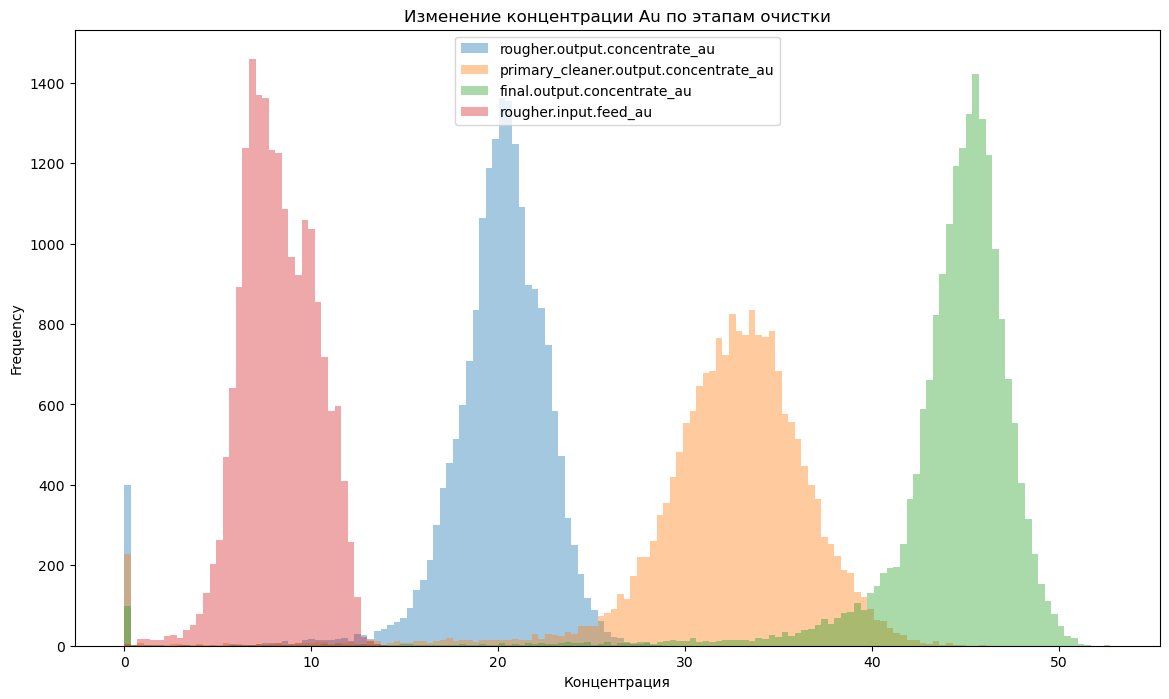

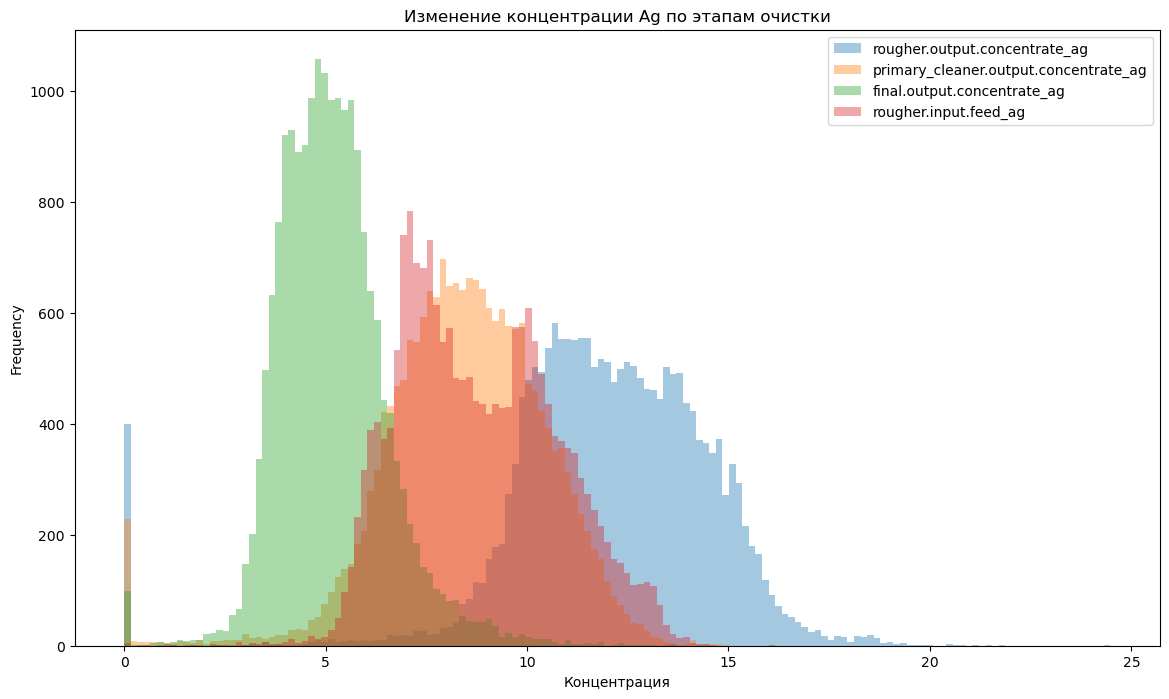

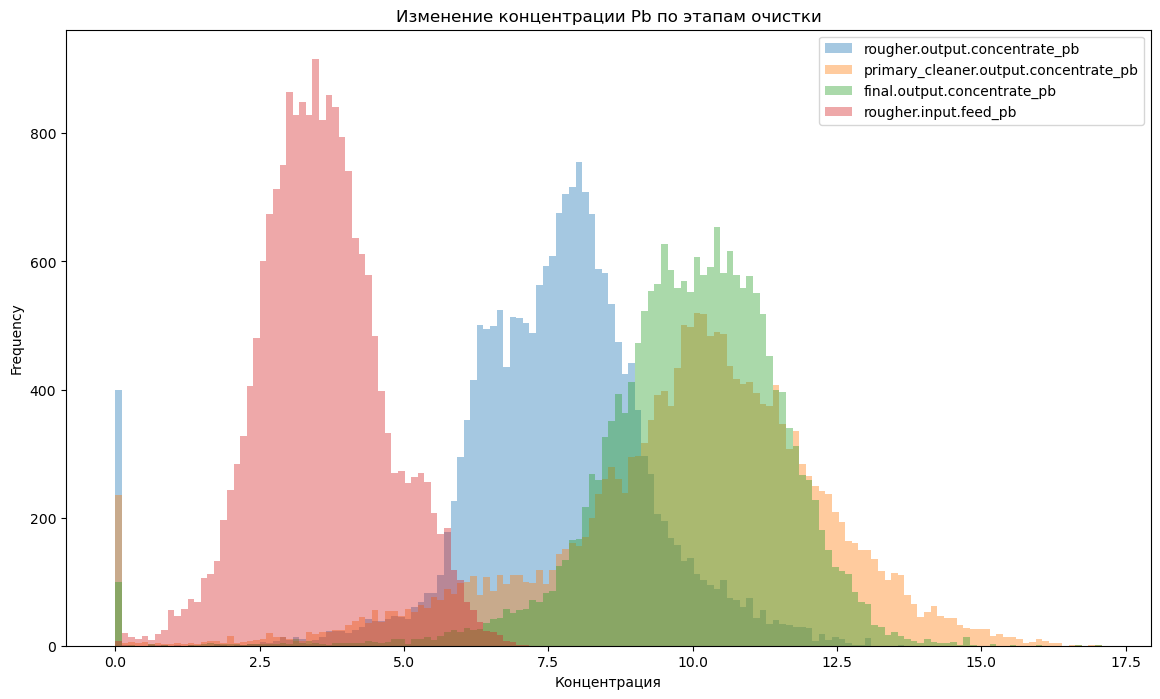

In [25]:
ag= ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag','rougher.input.feed_ag']
au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au','final.output.concentrate_au','rougher.input.feed_au']
pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb','rougher.input.feed_pb']

metalls = {"Au": au, "Ag": ag, "Pb": pb}
for metall in metalls:
    
    legend = 'Изменение концентрации ' + metall + ' по этапам очистки'
    
    fig, ax = plt.subplots()
    ax.set_title(legend)
    ax.set_xlabel('Концентрация')

    df_full[metalls[metall]].plot(kind='hist', bins=150, figsize=(14,8), ax=ax, legend=True, alpha=0.4)

### Выводы

- Концентрация золота увеличивается с каждым этапом очистки сырья - так и должно быть, в этом смысл процесса
- Концентарция серебра постепенно уменьшается
- Концентрация свинца также как и у золота увеличивается к финальными этапам очистки
- На графике присутствуют пики на нулевых значениях - скорее всего это выбросы, которые следует удалить

### Распределение размеров гранул сырья на обучающей и тестовой выборках

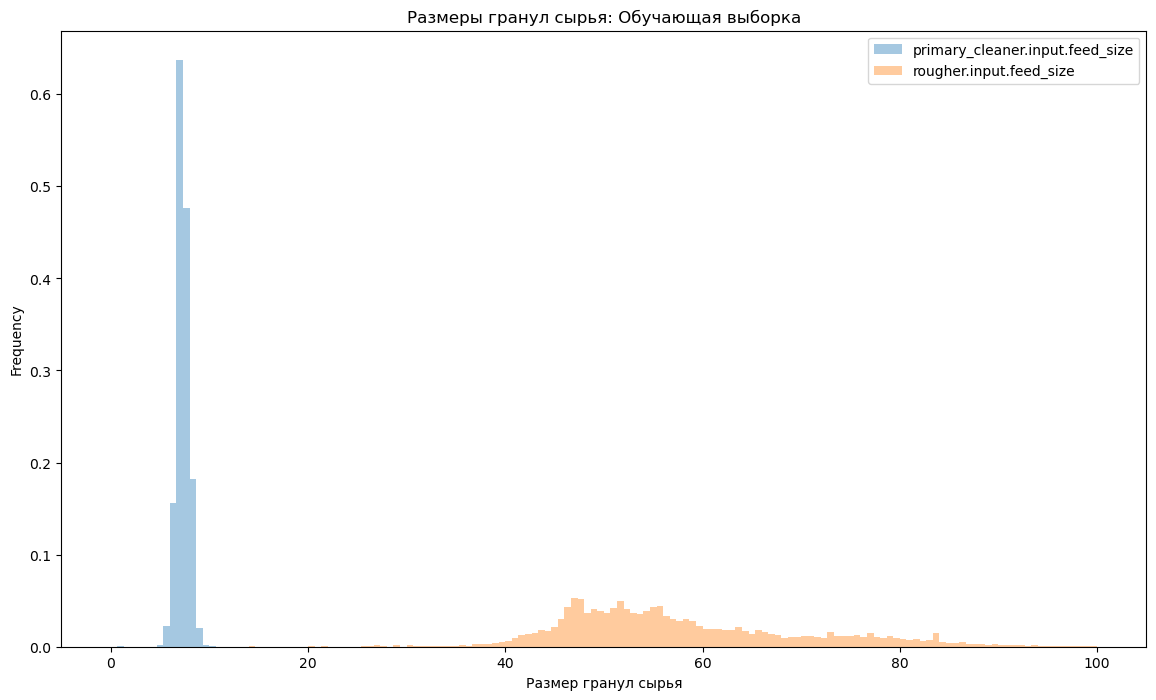

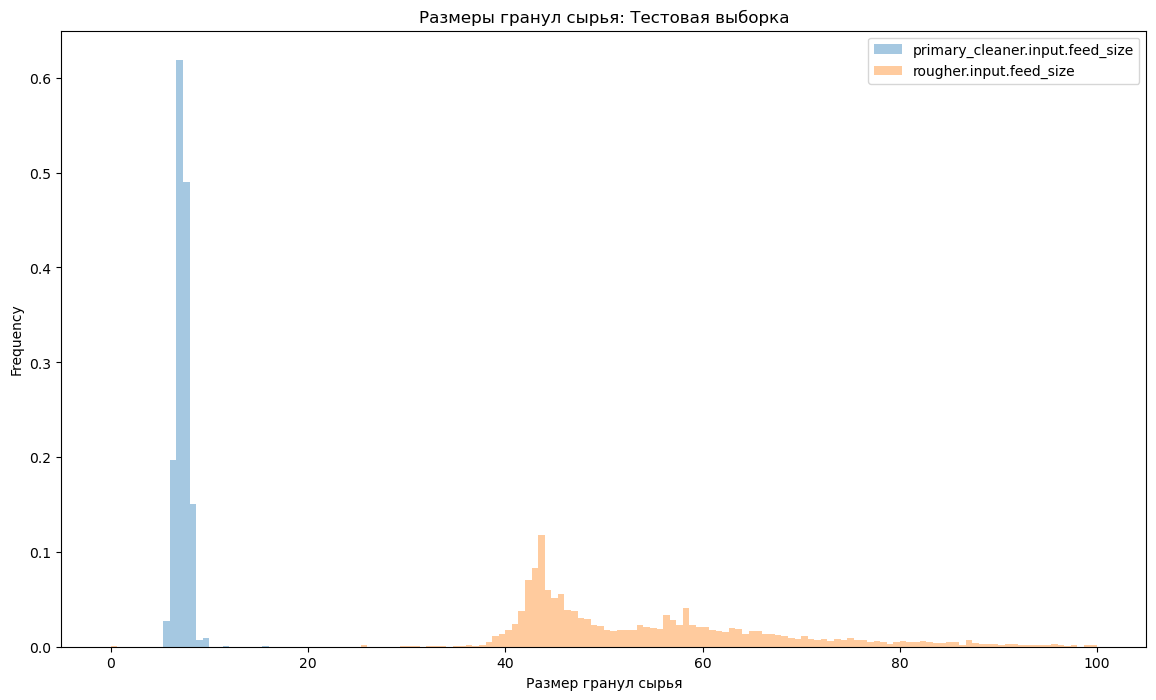

In [26]:
feed_size_dict = {"Обучающая выборка": df_train, "Тестовая выборка": df_test}
feed_size_columns = ['primary_cleaner.input.feed_size','rougher.input.feed_size']

for size in feed_size_dict:
    
    df = feed_size_dict[size]
    legend = 'Размеры гранул сырья: ' + size
    
    fig, ax = plt.subplots()
    ax.set_title(legend)
    ax.set_xlabel('Размер гранул сырья')

    df[feed_size_columns].plot(kind='hist', density=True, bins=150, range=(0,100), figsize=(14,8), ax=ax, legend=True, alpha=0.4)

### Выводы

- Гранулы исходного сырья значительно больше чем после очистки - это соотвествует смыслу технологии
- Обучающая и тестовая выборки показывают примерно одинаковые распределения размеров гранул сырья в зависимости от этапа очистки

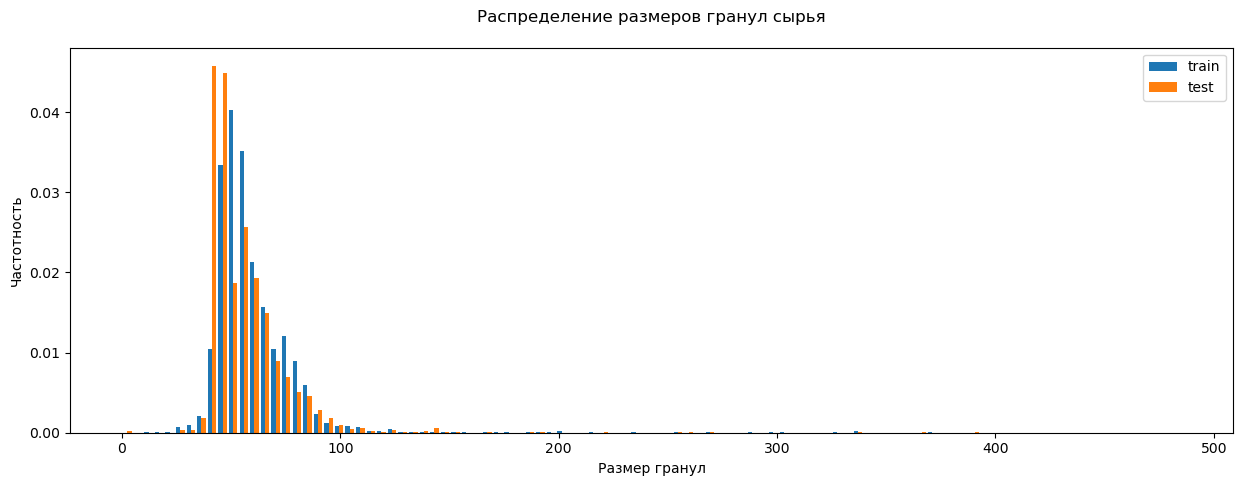

In [27]:
plt.figure(figsize=(15, 5))
plt.hist([df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']], bins=100,
        density=True)

plt.title('Распределение размеров гранул сырья'+ "\n")
plt.xlabel('Размер гранул')
plt.ylabel('Частотность')
plt.legend(['train', 'test'])

plt.show()

### Cуммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

<AxesSubplot:title={'center':'Распределение суммарного содержания металлов'}, xlabel='Концентрация металлов', ylabel='Frequency'>

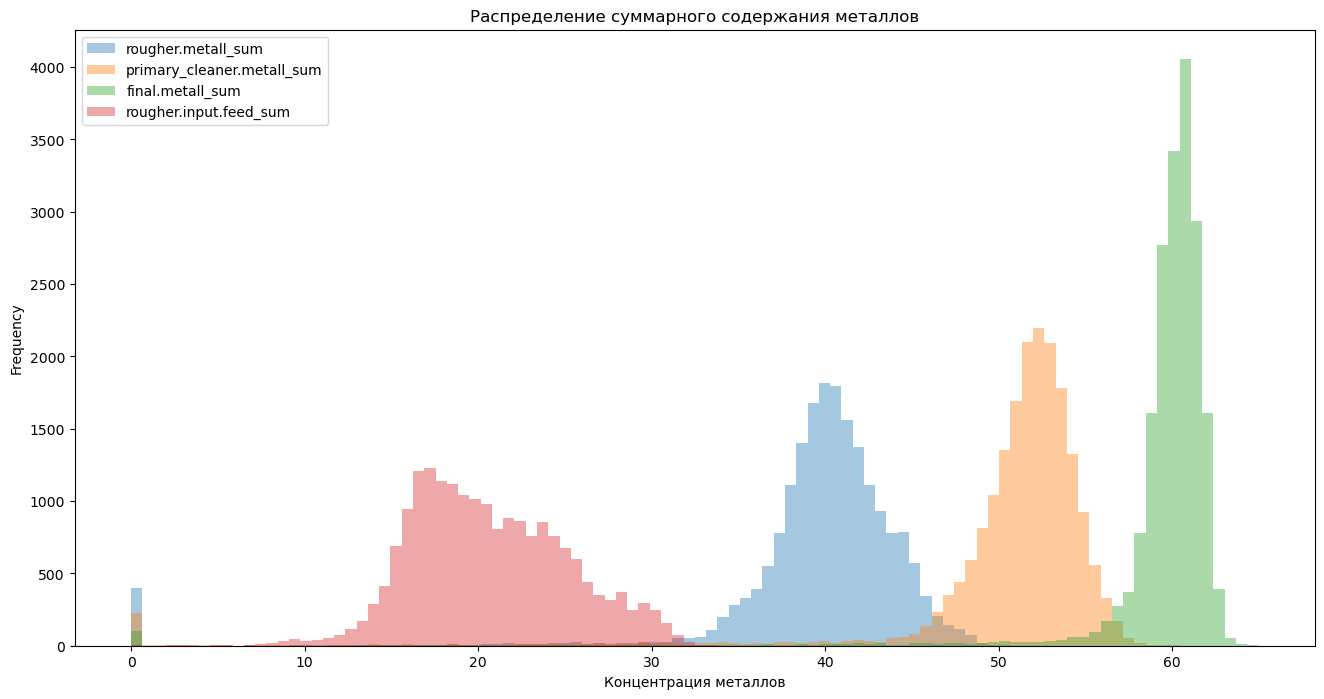

In [28]:
columns_sum = ['rougher.metall_sum', 'primary_cleaner.metall_sum', 'final.metall_sum','rougher.input.feed_sum']


df_full['rougher.metall_sum'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_au'] \
+ df_full['rougher.output.concentrate_pb']

df_full['primary_cleaner.metall_sum'] = df_full['primary_cleaner.output.concentrate_ag'] \
+ df_full['primary_cleaner.output.concentrate_au'] + df_full['primary_cleaner.output.concentrate_pb']

df_full['final.metall_sum'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_au'] \
+ df_full['final.output.concentrate_pb']

df_full['rougher.input.feed_sum'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_au'] \
+ df_full['rougher.input.feed_pb']

fig, ax = plt.subplots()
ax.set_title('Распределение суммарного содержания металлов')
ax.set_xlabel('Концентрация металлов')
df_full[columns_sum].plot(kind='hist', bins=100, figsize=(16,8), ax=ax, legend=True, alpha=0.4)

### Выводы

- Суммарная концентрация растет до максимальных значений к концу очистки - так должно быть
- Все еще присутствуют нулевые значения концентрации - это выбросы

### Обработка выбросов

- Определим и удалим выбросы данных - их совсем немного, но они будут негативно влиять на качество модели машинного обучения

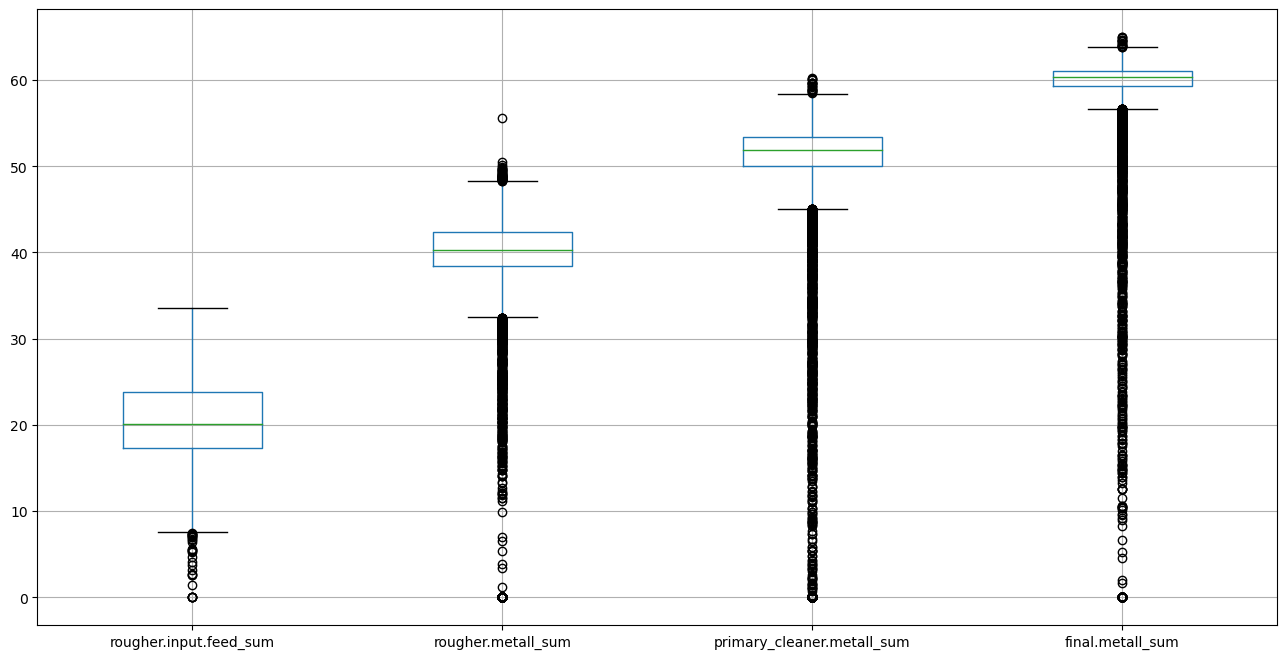

In [29]:
df_full.boxplot(column=['rougher.input.feed_sum','rougher.metall_sum', 'primary_cleaner.metall_sum', 'final.metall_sum']\
                , figsize=(16, 8))
plt.show()


- Установим критерий - отрежем хвосты boxpot снизу на необходимый минимум, чтобы не потерять более 3% данных
- Здесь не будем писать функцию, для каждого этапа - свой уровень

In [30]:
print(df_full[df_full['rougher.metall_sum'] > 20].value_counts().sum()/df_full['rougher.metall_sum'].value_counts().sum()*100)

print(df_full[df_full['primary_cleaner.metall_sum'] > 30].value_counts().sum()/df_full['primary_cleaner.metall_sum'].value_counts().sum()*100)

print(df_full[df_full['final.metall_sum'] > 45].value_counts().sum()/df_full['final.metall_sum'].value_counts().sum()*100)


97.49987139256135
97.11919337414476
97.73650907968518


<AxesSubplot:title={'center':'Распределение суммарного содержания металлов'}, xlabel='Концентрация металлов', ylabel='Frequency'>

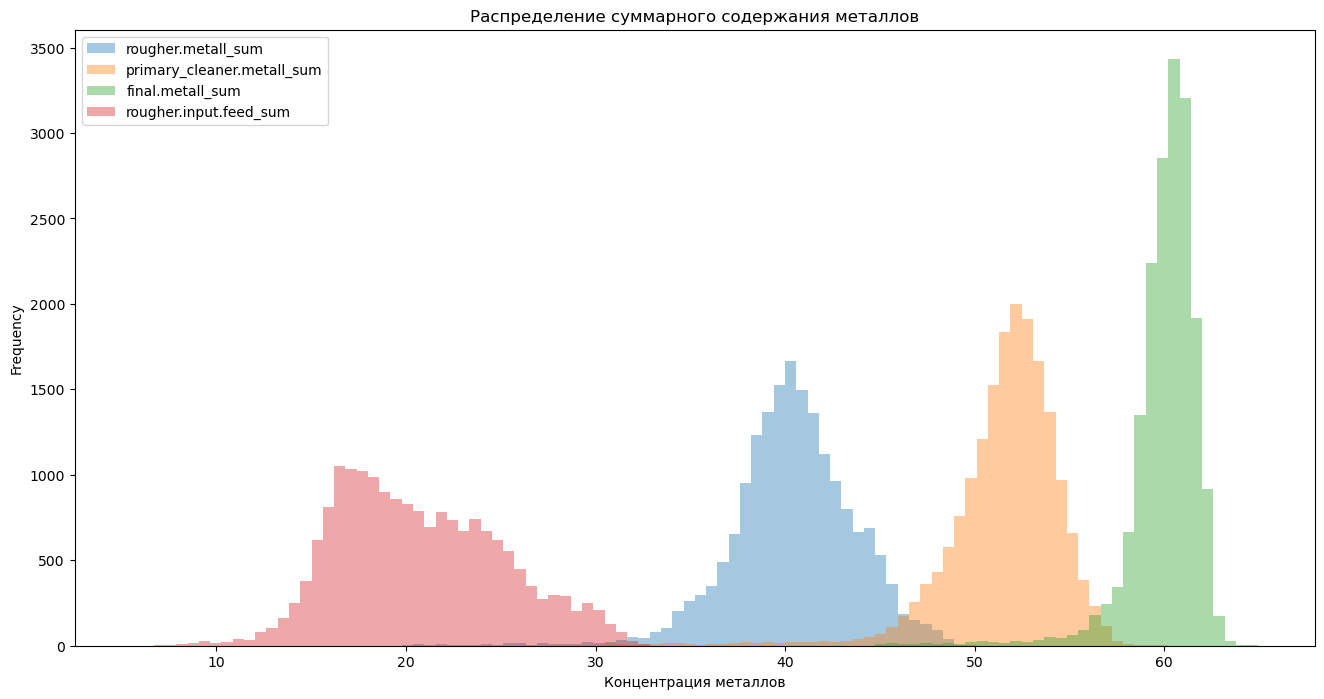

In [31]:
df_full=df_full[df_full['rougher.metall_sum'] > 20]
df_full=df_full[df_full['primary_cleaner.metall_sum'] > 30]
df_full=df_full[df_full['final.metall_sum'] > 45]

fig, ax = plt.subplots()
ax.set_title('Распределение суммарного содержания металлов')
ax.set_xlabel('Концентрация металлов')
df_full[columns_sum].plot(kind='hist', bins=100, figsize=(16,8), ax=ax, legend=True, alpha=0.4)


Переведем очищенные данные из общей выборки в обучающую и тестовую.


In [32]:
df_train = df_train[df_train.index.isin(df_full.index)]
df_test = df_test[df_test.index.isin(df_full.index)]

display(df_train.shape)
display(df_test.shape)

(13163, 52)

(4931, 52)

### Выводы 

- Выбросы удалены за счет очень небольшой потери данных. Это должно улучшить качество моделей при обучении

## Построение модели

### Функция для SMAPE

In [33]:
def smape(target, predicted):
    return 1/len(target) * np.sum(2 * np.abs(predicted-target) / (np.abs(target) + np.abs(predicted))*100)

In [34]:
def total_smape(rougher, final):
    return 0.25 * rougher + 0.75 * final
    

In [35]:
smape_score = make_scorer(smape)

### Выделение признаков

- Нужные столбцы (rougher.output.recovery и final.output.recovery) отсутствуют в обучающей и тестовой выборке. Подтянем их полной выборки

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13163 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13163 non-null  float64
 1   primary_cleaner.input.depressant            13163 non-null  float64
 2   primary_cleaner.input.feed_size             13163 non-null  float64
 3   primary_cleaner.input.xanthate              13163 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13163 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13163 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13163 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13163 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13163 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    13163 non-nu

In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               4931 non-null   float64
 1   primary_cleaner.input.depressant            4931 non-null   float64
 2   primary_cleaner.input.feed_size             4931 non-null   float64
 3   primary_cleaner.input.xanthate              4931 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      4931 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    4931 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      4931 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    4931 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      4931 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    4931 non-null

In [38]:
df_train_target = df_full[df_full.index.isin(df_train.index)][['rougher.output.recovery', 'final.output.recovery']]
df_train_target.head()

,rougher.output.recovery,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016


In [39]:
df_test_target = df_full[df_full.index.isin(df_test.index)][['rougher.output.recovery', 'final.output.recovery']]
df_test_target.head()

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078


- Судя по технологической последовательности процесса на разных этапах обработки на эффективность процесса влияют различные параметры


- **rougher.output.recovery (Черновой концентрат)**
    - На результаты очистки чернового концентрата должны влиять параметры флотации и входного сырья
    - Параметры последующих этапов очистки не будут иметь значения, так как находятся позже по технологическому процессу
    
    
- **final.output.recovery (Финальный концентрат)**
    - На результаты очистки финального концентрата должны влиять параметры первого и второго этапов очистки


- Выделим соовествующие признаки

In [40]:
columns_rougher_stage = ['rougher.input.feed_ag',                       
'rougher.input.feed_pb',                      
'rougher.input.feed_rate',                   
'rougher.input.feed_size',                   
'rougher.input.feed_sol',                     
'rougher.input.feed_au',                      
'rougher.input.floatbank10_sulfate',           
'rougher.input.floatbank10_xanthate',        
'rougher.input.floatbank11_sulfate',           
'rougher.input.floatbank11_xanthate',         
'rougher.state.floatbank10_a_air',            
'rougher.state.floatbank10_a_level',           
'rougher.state.floatbank10_b_air',             
'rougher.state.floatbank10_b_level',           
'rougher.state.floatbank10_c_air',             
'rougher.state.floatbank10_c_level',          
'rougher.state.floatbank10_d_air',            
'rougher.state.floatbank10_d_level',          
'rougher.state.floatbank10_e_air',            
'rougher.state.floatbank10_e_level',           
'rougher.state.floatbank10_f_air',             
'rougher.state.floatbank10_f_level']

In [41]:
columns_final_stage = ['primary_cleaner.input.sulfate',  
'primary_cleaner.input.depressant',            
'primary_cleaner.input.feed_size',             
'primary_cleaner.input.xanthate'  ,            
'primary_cleaner.state.floatbank8_a_air',      
'primary_cleaner.state.floatbank8_a_level',    
'primary_cleaner.state.floatbank8_b_air'   ,   
'primary_cleaner.state.floatbank8_b_level'  ,  
'primary_cleaner.state.floatbank8_c_air'    ,  
'primary_cleaner.state.floatbank8_c_level'  ,  
'primary_cleaner.state.floatbank8_d_air'    ,  
'primary_cleaner.state.floatbank8_d_level'  ,  
'secondary_cleaner.state.floatbank2_a_air'  ,  
'secondary_cleaner.state.floatbank2_a_level' , 
'secondary_cleaner.state.floatbank2_b_air'   , 
'secondary_cleaner.state.floatbank2_b_level' , 
'secondary_cleaner.state.floatbank3_a_air'   , 
'secondary_cleaner.state.floatbank3_a_level' , 
'secondary_cleaner.state.floatbank3_b_air'   , 
'secondary_cleaner.state.floatbank3_b_level' ,
'secondary_cleaner.state.floatbank4_a_air'   , 
'secondary_cleaner.state.floatbank4_a_level' , 
'secondary_cleaner.state.floatbank4_b_air'   , 
'secondary_cleaner.state.floatbank4_b_level' , 
'secondary_cleaner.state.floatbank5_a_air'   , 
'secondary_cleaner.state.floatbank5_a_level' , 
'secondary_cleaner.state.floatbank5_b_air'   , 
'secondary_cleaner.state.floatbank5_b_level' , 
'secondary_cleaner.state.floatbank6_a_air'   ,
'secondary_cleaner.state.floatbank6_a_level']
                       

In [42]:
df_rougher_train = df_train[columns_rougher_stage]
df_rougher_target = df_train_target['rougher.output.recovery']

df_final_train = df_train[columns_final_stage]
df_final_target = df_train_target['final.output.recovery']


df_rougher_train.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
2016-01-15 01:00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2016-01-15 02:00:00,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
2016-01-15 03:00:00,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
2016-01-15 04:00:00,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128


### Обучение моделей

- Необходимо попробовать обучать различные модели. Будем обучать два типа моделей - Линейная регрессия и Случайный лес

- В данных есть много числовых значений разной величины. Применим масштабирование

In [43]:
rougher_scaler = StandardScaler()

rougher_scaler.fit(df_rougher_train[columns_rougher_stage])
df_rougher_train[columns_rougher_stage] = rougher_scaler.transform(df_rougher_train[columns_rougher_stage])

final_scaler = StandardScaler()

final_scaler.fit(df_final_train[columns_final_stage])
df_final_train[columns_final_stage] = final_scaler.transform(df_final_train[columns_final_stage])


df_rougher_train.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-1.346933,-1.139258,0.474289,-0.201916,0.087153,-0.754132,0.074707,0.116729,0.121501,0.140534,...,1.533170,0.505250,1.408063,0.400649,1.838135,0.245830,1.693824,0.157085,2.152409,0.216275
2016-01-15 01:00:00,-1.314226,-1.156752,0.491586,-0.124431,-0.137010,-0.758181,0.069876,0.114663,0.165038,0.146142,...,1.520740,0.239467,1.399107,0.263862,1.845757,0.269937,1.665757,0.238503,2.057684,0.248535
2016-01-15 02:00:00,-1.338275,-1.255349,0.538551,-0.114400,-0.090647,-0.820453,0.054032,0.292686,0.144321,0.305091,...,1.512934,0.238507,1.395295,0.261640,1.842507,0.269927,1.665510,0.255029,2.061084,0.241303
2016-01-15 03:00:00,-1.377666,-1.368219,0.663140,-0.102203,0.098549,-0.951049,-0.036954,0.298075,0.082095,0.298423,...,1.516911,0.227842,1.396901,0.262430,1.832327,0.266763,1.674940,0.253388,2.060618,0.254350
2016-01-15 04:00:00,-1.368184,-1.600725,0.642727,-0.177677,-0.435632,-1.194269,-0.247526,0.294033,-0.117792,0.297032,...,1.517734,0.245639,1.398531,0.260208,1.842074,0.270725,1.678245,0.273825,2.065887,0.243429


- Масшабируем тестовую выборку

In [44]:
df_test[columns_rougher_stage] = rougher_scaler.transform(df_test[columns_rougher_stage])
df_test[columns_final_stage] = final_scaler.transform(df_test[columns_final_stage])


target_test_rough = df_test_target['rougher.output.recovery']
target_test_final = df_test_target['final.output.recovery']
features_test_rough = df_test[columns_rougher_stage]
feature_test_final = df_test[columns_final_stage]

#### Случайный лес (черновой концентрат)

- Параметры выставлены на единственное значение для экономии времени

In [45]:
for estim in range(50,51,10):
    for depth in range(5,6,1):
        model_r_forest = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        smape_score_rough_forest_reg = cross_val_score(model_r_forest, df_rougher_train, df_rougher_target, cv=5, scoring=smape_score)
        print('SMAPE =', smape_score_rough_forest_reg.mean(), 'при n_estimators =', estim, 'max_depth =',depth)

SMAPE = 6.317147972867028 при n_estimators = 50 max_depth = 5


#### Случайный лес (финальный концентрат)

- Параметры выставлены на единственное значение для экономии времени

In [46]:
for estim in range(50,51,10):
    for depth in range(5,6,1):
        model_r_forest = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        smape_score_final_forest_reg = cross_val_score(model_r_forest, df_final_train, df_final_target, cv=5, scoring=smape_score)
        print('SMAPE =', smape_score_final_forest_reg.mean(), 'при n_estimators =', estim, 'max_depth =',depth)

SMAPE = 11.075140097071257 при n_estimators = 50 max_depth = 5


Кросс-валидация дает несколько значений, возьмем средние

In [47]:
display(smape_score_rough_forest_reg)
display(smape_score_final_forest_reg)

smape_total_forest = total_smape(smape_score_final_forest_reg.mean(), smape_score_rough_forest_reg.mean())

print('SMAPE total RandomForestRegressor:', smape_total_forest)

array([9.65181276, 7.02008895, 4.49263709, 4.44222587, 5.97897519])

array([ 9.10022475, 16.85010922,  9.44622694,  9.31672096, 10.6624186 ])

SMAPE total RandomForestRegressor: 7.506646003918085


Для случайного леса наименьшая ошибка получилась при n_estimators=50 и max_depth = 5. **Используем эти параметры с тестовой выборкой**

In [48]:
forest_model_rough = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=12345)
forest_model_rough.fit(df_rougher_train, df_rougher_target)

forest_model_final = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=12345)
forest_model_final.fit(df_final_train, df_final_target)


RandomForestRegressor(max_depth=5, n_estimators=50, random_state=12345)

In [49]:
predict_forest_rough = forest_model_rough.predict(features_test_rough)
predict_forest_final = forest_model_final.predict(feature_test_final)

In [50]:
smape_rough_forest = smape(target_test_rough, predict_forest_rough)

smape_final_forest = smape(target_test_final, predict_forest_final)

#### Результат - SMAPE на тестовой выборке

In [51]:
smape_forest = total_smape(smape_rough_forest.mean(), smape_final_forest.mean())
print('SMAPE модели RandomForestRegressor на тестовой выборке:', smape_forest)

SMAPE модели RandomForestRegressor на тестовой выборке: 7.98804621661054


#### Линейная модель (черновой концентрат)

In [52]:
linear_model_rough = LinearRegression()
smape_score_rough_lin_reg = cross_val_score(linear_model_rough, df_rougher_train, df_rougher_target, cv=5, scoring=smape_score)
print('SMAPE =', smape_score_rough_lin_reg.mean())

SMAPE = 6.467848181821938


#### Линейная модель (финальный концентрат)

In [53]:
linear_model_final = LinearRegression()
smape_score_final_lin_reg = cross_val_score(linear_model_final, df_final_train, df_final_target, cv=5, scoring=smape_score)
print('sMAPE =', smape_score_final_lin_reg.mean())

sMAPE = 9.457394773403712


In [54]:
smape_final_lin = total_smape(smape_score_rough_lin_reg.mean(), smape_score_final_lin_reg.mean())
print('SMAPE final LinearRegression:', smape_final_lin)

SMAPE final LinearRegression: 8.710008125508267


Проверим на тестовой выборке

In [55]:
linear_model_rough = LinearRegression()
linear_model_rough.fit(df_rougher_train, df_rougher_target)
linear_model_final.fit(df_final_train, df_final_target)


LinearRegression()

In [56]:
predict_linear_rough = linear_model_rough.predict(features_test_rough)
predict_linear_final = linear_model_final.predict(feature_test_final)

In [57]:
smape_rough_linear = smape(target_test_rough, predict_linear_rough)
smape_final_linear = smape(target_test_final, predict_linear_final)

In [58]:
smape_linear_regr = total_smape(smape_rough_linear.mean(),smape_final_linear.mean())
print('SMAPE модели Linear Regression на тестовой выборке:', smape_linear_regr)

SMAPE модели Linear Regression на тестовой выборке: 6.895080728736744


### Сравнение с константой. Оценка адекватности

In [59]:
df_test['target_train_rough_mean'] = df_rougher_target.mean()

In [60]:
df_test['target_train_final_mean'] = df_final_target.mean()


In [61]:
smape_const = smape(df_test['target_train_rough_mean'], target_test_rough)*0.25 + smape(df_test['target_train_final_mean'], target_test_final)* 0.75
print( "SMAPE const : ", smape_const)

SMAPE const :  7.390413003211798


Показатели SMAPE лучше константы для Линейной регрессии

## Выводы

- Была выполнена загрузка и общий анализ данных, проверена корректность расчетов эффективности обогащения
- Определены значимые и лишние столбцы для анализа данных
- Обработаны пропуски и дубликаты
- Были проанализированы данные, изучены концентрации металлов в зависимости от этапа очистки, построены соовествующие графики
- Оценено распределение размеров гранул сырья по этапам очистки
- Было произведена оценка суммарной концентрации металлов, обработаны выбросы
- Рассчитана метрика SMAPE для двух различных моделей, подобраны гиперпарметры, модели оценены на адекватность
- По итогам работы наилучшие результаты показала модель Линейной регрессии с минимальным значением SMAPE